In the notebook `0maximum_views`, we focussed on those days with the most unexpected page views.

We wanted to investigate the following three roads:
- What if people don't only look for the current day, but also look one, two, three days ahead? (E.g., plan their weekend on Thursday)
- What if not the maximum unexpected page views are important, but rather large diffs?
- Do our observations change when we only look at daytime data, e.g., from 10.00 to 20.00, and delete nightly observations?

This is investigated in this notebook with the chapters
- Data preparation
- Diff computation
- Offset analysis (What's the weather like 1/2/3 days after a large diff)

In [1]:
import sys, os
import numpy as np
import pandas as pd

sys.path.append('../')

from datetime import datetime, timedelta
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
%matplotlib inline

from src import data_loader


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Preparation
Load data, and remove nightly observations (if wanted, can be commented out to include nightly observations).

In [2]:
p = Path("..") / "data" / "raw" / "data_windfinder"

name="10044" # 10028 is St. Peter Ording, 10044 is Kiel

weather_files = list(os.listdir(p))
weather_files = [file for file in weather_files if ("weatherdata" in file) and (name in file)]
weather_files = sorted(weather_files)

views_files = list(os.listdir(p))
views_files = [file for file in views_files if ("pageviews" in file) and (name in file)]
views_files = sorted(views_files)

In [3]:
# df = data_loader.load_data_by_facts()
dfs = pd.read_csv(p / weather_files[0], delimiter=';', parse_dates=[0])
for fn in weather_files[1:]:
    df = pd.read_csv(p / fn, delimiter=';', parse_dates=[0])
    dfs = dfs.append(df)
    
dfs.drop(['wind gust [kts]'], axis=1, inplace=True)
dfs.dropna(inplace=True)

rename_dict = {'date/time (UTC)': 'date', 'wind speed [kts]': 'wind_speed', 'wind direction [degrees]': 'wind_direction', 'air temperature [°C]': 'temp'}
dfs.rename(columns=rename_dict, inplace=True)

df = dfs

In [4]:
def add_date_no_time(df: pd.DataFrame, date_columns: str = "date"):
    df['date_no_time'] = df.apply(lambda row: datetime(year=row[date_columns].year, month=row[date_columns].month, day=row[date_columns].day), axis=1)
    
def remove_night_time(df: pd.DataFrame, date_column: str = "date", first_hour_to_include: int = 10, last_hour_to_include: int = 21):
    """
    Remove observations that happened at night time. What night time means can be changed with the parameters.
    """
    list_of_hours_to_include = set(range(first_hour_to_include, last_hour_to_include+1))
    mask = df.apply(lambda row: row[date_column].hour in list_of_hours_to_include, axis=1)
    return df[mask]

In [5]:
add_date_no_time(df)
df = remove_night_time(df)

In [20]:
# df

In [7]:
years = [2016, 2017, 2018, 2019]
views_files

df_all_views = pd.read_csv(p / views_files[0], delimiter=';', parse_dates=[0], header=None, names=['date', 'counts_2016'])
df_views = pd.read_csv(p / views_files[0], delimiter=';', parse_dates=[0], header=None, names=['date', 'counts'])


for y, fn in list(zip(years, views_files))[1:]:
    df_views_year = pd.read_csv(p / fn, delimiter=';', parse_dates=[0], header=None, names=['date', f'counts'])
    df_all_views[f"counts_{str(y)}"] = df_views_year[f"counts"]
    df_views = df_views.append(df_views_year)
    
# df_all_views = add_weekdays_onehot(df_all_views, 'date')

In [8]:
df_views

,date,counts
0,2016-01-01,1330
1,2016-01-02,2232
2,2016-01-03,1977
3,2016-01-04,1784
4,2016-01-05,1636
...,...,...
360,2019-12-27,743
361,2019-12-28,687
362,2019-12-29,853
363,2019-12-30,1110


In [9]:
df_views.set_index('date', inplace=True)

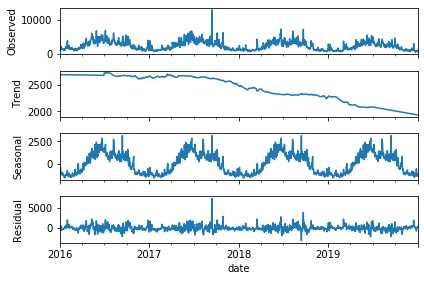

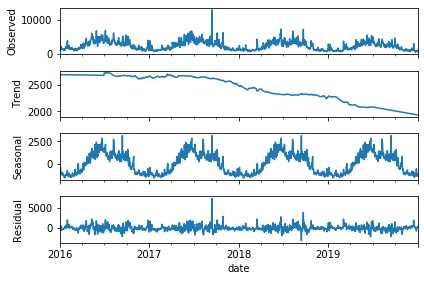

In [10]:
result=seasonal_decompose(df_views['counts'], model='additive', freq=365, extrapolate_trend='freq')
result.plot()

In [11]:
# fig = result.plot()
# fig.savefig("Kiel_decompose_all.png")

## Diff computation
This includes calculating the diffs and filtering top x percent diffs.

In [12]:
## PARAMETER
top_x = 0.05

#calculate diff
df_views_resid = pd.DataFrame({'counts': result.resid})
df_views_resid_diff = df_views_resid.diff()

In [13]:
# find largest diffs
values = df_views_resid.diff().values.reshape(-1)
values.sort()
split_value = values[int(len(values) * (1-top_x))]
mask = df_views_resid_diff > split_value

## Offset analysis
Note that when changing `offset_from_large_diff`, rerun cells starting at Diff computation.

In [14]:
# PARAMETER
offset_from_large_diff = 1 # example: 2 means 2 days after, e.g., large diff on Thursday, weather on Saturday

dates = df_views_resid_diff.index
dates = dates[offset_from_large_diff:]
mask = mask.values[:-offset_from_large_diff].reshape(-1) # use this when offset_form_large_diff > 0. Else comment out and use next line
# mask = mask.values.reshape(-1) # only use when offset_from_large_diff is 0
dates_with_offset = dates[mask]

In [15]:
# dates_with_offset

In [16]:
df_mask = df.apply(lambda row: row.date_no_time in dates_with_offset, axis=1)
df_masked = df[df_mask]

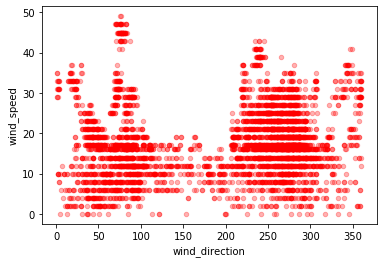

In [17]:
ax = df_masked.plot.scatter(x='wind_direction', y='wind_speed', alpha=.3, color='r')
# ax.set_ylim([-2, 52])
# fig = ax.get_figure()
# fig.savefig(f'Kiel_diffs_offset{offset_from_large_diff}_10_to_21.png')

In [18]:
# fig = df_masked.plot.scatter(x='wind_direction', y='wind_speed', alpha=.3, color='r').get_figure()
# fig.savefig(f'Kiel_diffs_offset{offset_from_large_diff}_all.png')

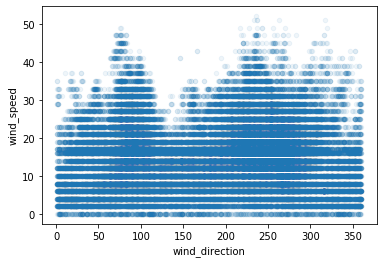

In [19]:
# again: all observations
fig = df.plot.scatter(x='wind_direction', y='wind_speed', alpha=.07).get_figure()
# fig.savefig(f'SPO_all_10_to_21.png')